## Assignment 06

**Students:**
- Franklin Ruben Rosembluth Prado
- Sharon Sarai Maygua Mendiola

In [479]:
import numpy as np
import gym
from gym import spaces
import random
from copy import copy
from termcolor import colored, cprint
import time
import math
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize, ListedColormap
from PIL import Image

In [480]:
# 0 = empty_space; 1 = init_pos; 2 = goal_pos
def create_map(size, init_position, goal_pos):
    map = np.zeros((size[1], size[0]), dtype=np.int)
    map[init_position[1], init_position[0]] = 1
    map[goal_pos[1], goal_pos[0]] = 2
    return map

In [481]:
map_size = (9, 7)
init_pos = (1, 1)
goal_pos = (7, 4)
map = create_map(map_size, init_pos, goal_pos)
print(map)

[[0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]


In [482]:
action_space_size = 8 #UP, RIGHT, DOWN, LEFT UP_RIGHT, ..., DOWN_LEFT
state_space_size = map_size[0] * map_size[1] #AREA
print(action_space_size, state_space_size)

q_table = np.zeros((state_space_size, action_space_size))

print(q_table.shape)

8 63
(63, 8)


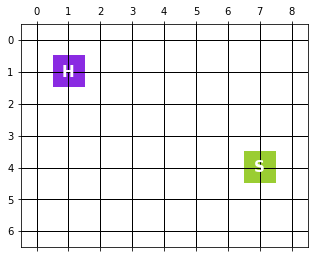

In [483]:
def show_map(map):
    row_labels, col_labels = range(map.shape[0]), range(map.shape[1])
    cmap = ListedColormap(['white', 'blueviolet', 'yellowgreen'])
    norm = Normalize(vmin=0, vmax=2)
    plt.matshow(map, cmap=cmap, norm=norm)
    plt.xticks(col_labels, col_labels)
    plt.yticks(row_labels, row_labels)
    plt.grid(color='k', linewidth=1)
    init = np.where(map == 1)
    plt.text(init[1][0], init[0][0], 'H', ha='center', va='center', color='white', weight='bold', fontsize=15)
    goal = np.where(map == 2)
    plt.text(goal[1][0], goal[0][0], 'S', ha='center', va='center', color='white', weight='bold', fontsize=15)
    plt.show()

show_map(map)

Creating environment from:
- https://www.gymlibrary.dev/content/environment_creation/

In [484]:
class AzkabanEnviroment:
    def __init__(self, map, size, init_pos, goal_pos, prob_A=0.9, prob_B=0.8, prob_C=0.9):
        self.map = map
        self.size = size
        self.harry_pos = init_pos
        self.sirius_pos = goal_pos
        self.reset_map = map
        self.reset_harry_pos = init_pos
        self.action_space = spaces.Discrete(8)
        self.observation_space = spaces.Discrete(self.map.shape[0] * self.map.shape[1])
        self.prob_A = prob_A
        self.prob_B = prob_B
        self.prob_C = prob_C
        self._action_to_direction = {
            0: "left",
            1: "right",
            2: "up",
            3: "down",
            4: "up_right",
            5: "up_left",
            6: "down_right",
            7: "down_left"
        }
        self.rewards = {
            "walk": -1,
            "fall": -5,
            "goal": 100
        }
    
    def get_actions(self, action):
        return self._action_to_direction[action]
    
    def get_rewards(self):
        return self.rewards
    
    def set_rewards(self, walk , fall, goal):
        self.rewards = {
            "walk": walk,
            "fall": fall,
            "goal": goal
        }

    def __str__(self):
        return f"Harry Position: ({self.harry_pos[0]}, {self.harry_pos[1]})\n" + str(self.map)

    def render(self):
        row_labels, col_labels = range(self.map.shape[0]), range(self.map.shape[1])
        cmap = ListedColormap(['white', 'blueviolet', 'yellowgreen'])
        norm = Normalize(vmin=0, vmax=2)
        plt.matshow(self.map, cmap=cmap, norm=norm)
        plt.xticks(col_labels, col_labels)
        plt.yticks(row_labels, row_labels)
        plt.grid(color='k', linewidth=1)
        init = np.where(self.map == 1)
        plt.text(init[1][0], init[0][0], 'H', ha='center', va='center', color='white', weight='bold', fontsize=15)
        goal = np.where(self.map == 2)
        plt.text(goal[1][0], goal[0][0], 'S', ha='center', va='center', color='white', weight='bold', fontsize=15)
        plt.show()
    
    def reset(self):
        self.map = self.reset_map
        self.harry_pos = self.reset_harry_pos
        return ((10 * self.harry_pos[0]) + self.harry_pos[1]) #given state

    def is_goal_state(self):
        return self.harry_pos == self.sirius_pos
    
    def has_fallen_of_map(self):
        x_range = np.array(range(self.size[0]))
        y_range = np.array(range(self.size[1]))
        return (self.harry_pos[0] not in x_range) or (self.harry_pos[1] not in y_range)
    
    def move_harry_right(self):
        self.harry_pos = list(self.harry_pos)
        self.harry_pos[0] += 1
        self.harry_pos = list(self.harry_pos)
        return self.get_move_result()

    def move_harry_left(self):
        self.harry_pos = list(self.harry_pos)
        self.harry_pos[0] -= 1
        self.harry_pos = list(self.harry_pos)
        return self.get_move_result()
    
    def move_harry_up(self):
        self.harry_pos = list(self.harry_pos)
        self.harry_pos[1] -= 1
        self.harry_pos = list(self.harry_pos)
        return self.get_move_result()

    def move_harry_down(self):
        self.harry_pos = list(self.harry_pos)
        self.harry_pos[1] += 1
        self.harry_pos = tuple(self.harry_pos)
        return self.get_move_result()
    
    def move_harry_up_right(self):
        self.move_harry_up()
        self.move_harry_right()
        return self.get_move_result()

    def move_harry_up_left(self):
        self.move_harry_up()
        self.move_harry_left()
        return self.get_move_result()

    def move_harry_down_right(self):
        self.move_harry_down()
        self.move_harry_right()
        return self.get_move_result()

    def move_harry_down_left(self):
        self.move_harry_down()
        self.move_harry_left()
        return self.get_move_result()
    
    def get_move_result(self):
        move = (10 * self.harry_pos[0] + self.harry_pos[1]) #state
        if self.is_goal_state():
            return move, self.rewards["goal"], True
        if self.has_fallen_of_map():
            return move, self.rewards["fall"], True
        
        self.map = create_map(self.size, self.harry_pos, self.sirius_pos)
        return move, self.rewards["walk"], False
        
    def step(self, action):
        direction = self._action_to_direction[action]
        if direction == "left":
            new_state, reward, done = self.move_harry_left()
        elif direction == "right":
            new_state, reward, done = self.move_harry_right()
        elif direction == "up":
            new_state, reward, done = self.move_harry_up()
        elif direction == "down":
            new_state, reward, done = self.move_harry_down()
        elif direction == "up_right":
            new_state, reward, done = self.move_harry_up_right()
        elif direction == "up_left":
            new_state, reward, done = self.move_harry_up_left()
        elif direction == "down_right":
            new_state, reward, done = self.move_harry_down_right()
        elif direction == "down_left":
            new_state, reward, done = self.move_harry_down_left()
            
        # probability windy columns
        if self.harry_pos[0] == 3:
            random_number = np.random.rand()
            if random_number <= self.prob_A:
                new_state, reward, done = self.move_harry_up()

        if self.harry_pos[0] == 4:
            random_number = np.random.rand()
            if random_number <= self.prob_B:
                new_state, reward, done = self.move_harry_up()
                new_state, reward, done = self.move_harry_up()

        if self.harry_pos[0] == 5:
            random_number = np.random.rand()
            if random_number <= self.prob_C:
                new_state, reward, done = self.move_harry_up()

        return new_state, reward, done

Create Azkaban environment as follows:

In [485]:
map_size = (9, 7)
init_pos = (1, 1)
goal_pos = (7, 4)
azkaban_map = create_map(map_size, init_pos, goal_pos)
env = AzkabanEnviroment(azkaban_map, map_size, init_pos, goal_pos)

Render the environment:

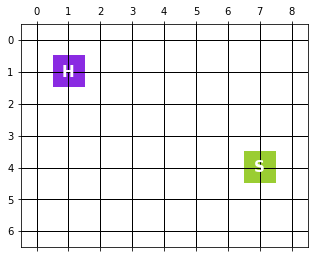

In [486]:
env.render()

Get states and actions for the lake.

In [487]:
action_space_size = env.action_space.n
state_space_size = env.observation_space.n

print((action_space_size, state_space_size))

(8, 63)


Move the agent: 

down_left


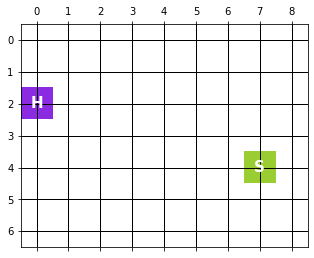

In [488]:
action = env.action_space.sample()
state = env.reset() #*10
new_state, reward, done = env.step(action)
print(env.get_actions(action))
env.render()

Initialize some parameters.

In [489]:
num_episodes = 3000 #15000
max_steps_per_episode = 200 #100

learning_rate = 0.1
discount_rate = 0.95

rewards_avg = []

q_table = np.zeros((state_space_size, action_space_size))

print(q_table.shape)

(63, 8)


Run Q-Learning algorithm:

In [490]:
def train_q_table(env, rewards_avg, iteration=100):
    for it in range(iteration):
        print('average ', it )
        rewards_all_episodes=[]

        # exporation-exploitation trade-off params
        exploration_rate = 1
        max_exploration_rate = 1
        min_exploration_rate = 0.01
        exploration_decay_rate = 0.005

        # init q table in zeros
        q_table = np.zeros((100, action_space_size))

        # iterate over the episodes
        for episode in range(num_episodes):
            state = env.reset()
            done = False
            rewards_current_episode = 0

            # iterate over the steps for an episode
            for step in range(max_steps_per_episode):
                # Exploration-exploitation trade-off
                exploration_rate_threshold = np.random.rand()
                if exploration_rate_threshold <= exploration_rate:
                    # Explotation time
                    action = np.random.randint(0, action_space_size)
                else:
                    # Explotation time
                    action = np.argmax(q_table[state])

                # Take action
                new_state, reward, done = env.step(action)

                # Update Q-table for Q(s,a)
                #q_table[state, action] = (1 - learning_rate) * q_table[state, action] + learning_rate * (reward + discount_rate * np.max(q_table[new_state]))
                q_table[state, action] = (1-learning_rate) * q_table[state, action] + learning_rate * (reward + discount_rate * np.max(q_table[new_state]))
                
                # transition next state
                state = new_state
                rewards_current_episode += reward

                if done == True: 
                    break


            # Exploration rate decay
            #exploration_rate = min_exploration_rate + (max_exploration_rate - min_exploration_rate) * (math.e ** (-exploration_decay_rate * episode))
            exploration_rate = min_exploration_rate + (max_exploration_rate - min_exploration_rate) * (np.exp(-exploration_decay_rate * episode)) #your code here
            rewards_all_episodes.append(rewards_current_episode)

        rewards_avg.append(rewards_all_episodes)
    return q_table

In [491]:
# Applying Q-learning
walk_reward = -1
fall_reward = -10
goal_reward = 100
rewards_avg_test = []

env.reset()
env.set_rewards(walk_reward , fall_reward, goal_reward)
q_table_1 = train_q_table(env, rewards_avg_test, 100)

average  0
average  1
average  2
average  3
average  4
average  5
average  6
average  7
average  8
average  9
average  10
average  11
average  12
average  13
average  14
average  15
average  16
average  17
average  18
average  19
average  20
average  21
average  22
average  23
average  24
average  25
average  26
average  27
average  28
average  29
average  30
average  31
average  32
average  33
average  34
average  35
average  36
average  37
average  38
average  39
average  40
average  41
average  42
average  43
average  44
average  45
average  46
average  47
average  48
average  49
average  50
average  51
average  52
average  53
average  54
average  55
average  56
average  57
average  58
average  59
average  60
average  61
average  62
average  63
average  64
average  65
average  66
average  67
average  68
average  69
average  70
average  71
average  72
average  73
average  74
average  75
average  76
average  77
average  78
average  79
average  80
average  81
average  82
average  83
av

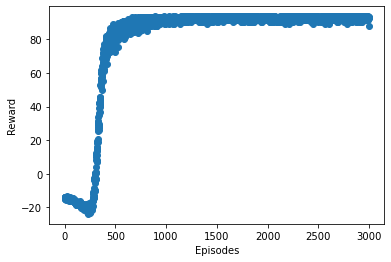

In [494]:
x = [i for i in range(0, num_episodes)]
y = np.mean(rewards_avg_test, axis=0)
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.plot(x, y,'o')

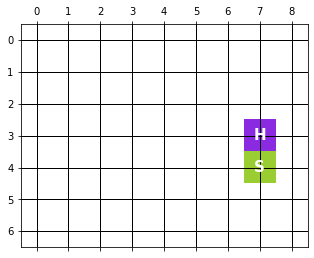

In [495]:
env.render()